In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
###Change the data file directory below appropriately
data = pd.read_csv('../raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv')
#data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1449601597,1.000371,0.007671,-0.016173,0.027860,0.998221,1.000739,1.003265,0.891038,6.684582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,1449601657,1.000243,0.003782,-0.002713,0.007046,0.998463,1.000373,1.002088,1.647929,6.684605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1449601717,1.000811,0.002082,-0.001922,0.003575,0.999653,1.000928,1.002032,1.960286,6.684610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,1449601777,1.001245,0.004715,-0.002895,0.008881,0.999188,1.001425,1.003500,1.614524,6.684601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,1449601855,1.001354,0.065186,-0.096520,0.165298,1.000807,1.002259,1.003631,0.837790,6.682252,...,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2


# Interpolating acceleration columns with average values

In [3]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Splitting the data and loading it into a PyTorch dataloader

In [4]:
X = data.iloc[:,1:27]
y = data[['label:SITTING']]

X = X[y['label:SITTING'] == 1]
y = y[y['label:SITTING'] == 1]

X = interpolation(X).values
y = interpolation(y).values

print(len(X), len(y))

2253 2253


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X

# Helper Functions for Training

In [6]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, int(hidden_dim/2)),
            generator_block(int(hidden_dim/2), int(hidden_dim/4)),
            generator_block(int(hidden_dim/4), 30),
            generator_block(30, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),                   
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    #loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    #loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = -(torch.mean(pred_real) - torch.mean(pred_fake))
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features)
    #gen_loss = criterion(pred, torch.ones_like(pred))
    gen_loss = -torch.mean(pred_fake)
    return gen_loss

def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()
    
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()
    
def performance_stats(gen, disc, b_size, batch = None):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    with torch.no_grad():
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * b_size
            y_label = torch.Tensor(y_label)
        else:
            latent_vectors = get_noise(int(b_size/2), z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * int(b_size/2)
            
            real_y_hat = torch.round(disc(batch[:int(b_size/2)]))
            for i in range(0, int(b_size/2)):
                y_label.append(1)
            y_hat = torch.cat((y_hat, real_y_hat), dim = 0)
            
            #print(y_hat)
            #print(y_label)
         
        
        for k in range(len(y_hat)):
            #True positive
            if y_label[k] == 1 and y_hat[k] == 1:
                tp += 1
            #False Negative
            elif y_label[k] == 1 and y_hat[k] == 0:
                fn += 1
            #True Negative
            elif y_label[k] == 0 and y_hat[k] == 0:
                tn += 1
            elif y_label[k] == 0 and y_hat[k] == 1:
                fp += 1
            else:
                print("Error")
                exit()
            
        class_acc = (tp + tn)/(tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
            
        if fp + tn == 0:
            fpR = 0
        else: 
            fpR = fp / (fp + tn)

        #print(f'Classification Accuracy: {class_acc:.2f}')
        #print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        #print(f'F-1 Score: {2*(precision * recall / (precision + recall + 0.001)):.2f}')
        return class_acc, precision, recall, fpR, 2*(precision * recall / (precision + recall + 0.001))
    
    
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    fake_features = gen(latent_vectors)
    
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim


def all_Wasserstein_dists(gen, z_dim, feature_dim, sample):
    wasser_dim = []
    latent_vectors = get_noise(len(sample), z_dim)
    fake_features = gen(latent_vectors)
    for k in range(feature_dim):
        wasser_dim.append(wasserstein_distance(fake_features[:, k].detach().numpy(), sample[:, k].detach().numpy()))
    return torch.tensor(wasser_dim)

# Model Hyperparameters (Always Run Again Before Starting Training Loop) 

In [7]:
# Loss function for model
criterion = ""

#GAN Name (used for saving model and its output)
gan_id = "Test Gan"

# Digit Precision for printouts
dig = 5

# Max epochs to run
n_epochs = 600

# Number of dimensions of output from generator
feature_dim = 26

# Number of dimensions of latent vector
z_dim = 100

# Batch Size
batch_size = 100

# Learning Rates for Generator (Gen) and Discriminator (Disc)
gen_lr =  0.00001
disc_lr = 0.00001

# Constant epochs approach to train Discriminator, Generator
constant_train_flag = True # Set to true to train based on constant # of epochs per machine 
                            # Set to false to train dynamically based on machine performance
disc_epochs = 5             # Number of consecutive epochs to train discriminator before epoch threshold
gen_epochs = 2              # Number of consecutive epochs to train generator before epoch threshold
epoch_threshold = 5000        # Epoch number to change training epoch ratio
disc_epochs_change = 1      # New number of consecutive epochs to train discriminator
gen_epochs_change = 50      # New number of consecutive epochs to train generator
rel_epochs = 0              # Epochs passed since last switch (always set to 0)


# Dynamic number of epochs to train Discriminator, Generator
static_threshold = 18   # Epoch number to change from static ratio to dynamic
static_disc_epochs = 4  # Number of consecutive epochs to train discriminator before epoch threshold
static_gen_epochs = 2   # Number of consecutive epochs to train generator before epoch threshold
pull_threshold = 0.4    # Accuracy threshold for switching machine training when the generator is no longer competitive
push_threshold = 0.6    # Accuracy threshold for switching machine training when the discriminator is no longer competitive
recall_threshold = 0.85

# Which machine to train (0 for Generator, 1 for Discriminator) !!!(do not change unless for good reason)!!!
GENERATOR = 0
DISCRIMINATOR = 1
to_train = DISCRIMINATOR
train_string = "DISC"

# Show model performance per batch (will always show summary for each epoch)
print_batches = False

# Moving corpus data into a pyTorch format !!!(do not change unless for good reason)!!!
train_features = torch.tensor(X)
train_labels = torch.tensor(y)
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

# Initializiing the Machines !!!(do not change unless for good reason)!!!
disc = Discriminator()
gen = Generator(z_dim)
opt_gen = optim.RMSprop(gen.parameters(), lr=gen_lr)
opt_disc = optim.RMSprop(disc.parameters(), lr=disc_lr)

# Training Loop

In [8]:
#For saving prettyTable.txt file
heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "Median Wasserstein", "Mean Wasserstein"]
table = PrettyTable()
table.field_names = heading

#For saving .csv file
rows = []

last_real_features = []
switch_flag = False
switch_count = 0

for epoch in range(n_epochs):  
    if constant_train_flag:
        if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

        elif to_train == GENERATOR and rel_epochs >= gen_epochs:
            rel_epochs = 0
            to_train = DISCRIMINATOR
            train_string = "DISC"
        
        # Change epoch ratio after intial 'leveling out'
        if epoch == epoch_threshold:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

            old_ratio = gen_epochs / disc_epochs
            gen_epochs = gen_epochs_change
            disc_epochs = disc_epochs_change
            new_ratio = gen_epochs / disc_epochs
            print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
    else:
        if epoch < static_threshold:
            if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
        
        else:
            to_train = DISCRIMINATOR
            train_string = "DISC"
            if not switch_flag:
                print("\nSwitching to Dynamic Training\n")
                switch_flag = True
            if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                to_train = GENERATOR
                train_string = "GEN"
                print("\nPull Generator\n")
                switch_count += 1
            if to_train == GENERATOR and fpR >= push_threshold:
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nPush Generator\n")
                switch_count += 1

    print(f'Epoch [{epoch + 1}/{n_epochs}] Training: {train_string} ', end ='')
    for batch_idx, (real_features, _) in enumerate(train_loader):
        #batch_size = len(real_features)
    
        if print_batches:
                print(f'\n\tBatch [{batch_idx + 1} / {len(train_loader)}] |', end ='')
    
        if to_train == DISCRIMINATOR:
            ### Training Discriminator
            #visualize_real_batch(real_features.float())
            opt_disc.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim)
            disc_loss.backward(retain_graph = True)
            opt_disc.step()
            for p in disc.parameters():
                p.data.clamp_(-0.01, 0.01)
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        else:
            ### Training Generator
            opt_gen.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
            gen_loss.backward()
            opt_gen.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        
    if not print_batches:
        if to_train == DISCRIMINATOR:
            print(f'| Loss D: {disc_loss.item():.{dig}f}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} |  Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
        else:
            print(f'| Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Generator", f"{get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}", f"{gen_loss.item():.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
    rel_epochs += 1

    
print("\n\nTraining Session Finished")
print(f"Encountered {switch_count} non-trivial training swaps")

f = open("../model_outputs/" + gan_id + ".txt", "w")
f.write(table.get_string())
f.close()
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".txt\"")

with open("../model_outputs/" + gan_id + ".csv", "w") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(heading)
    # writing the data rows 
    csvwriter.writerows(rows)
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".csv\"")

Epoch [1/600] Training: DISC | Loss D: 0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.50831 | Mean Wasserstein: 0.53198
Epoch [2/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01012 |  Median Wasserstein: 0.47233 | Mean Wasserstein: 0.46639
Epoch [3/600] Training: DISC | Loss D: -0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.52758 | Mean Wasserstein: 0.54216
Epoch [4/600] Training: DISC | Loss D: 0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.42898 | Mean Wasserstein: 0.45432
Epoch [5/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.41273 | Mean Wasserstein: 0.42327
Epoch [6/600] Training: GEN | Loss D: 0.00001, Loss G: -0.01009 | Median Wasserstein: 0.43997 | Mean Wasserstein: 0.46600
Epoch [7/600] Training: GEN | Loss D: 0.00000, Loss G: -0.01011 | Median Wasserstein: 0.48001 | Mean Wasserstein: 0.48927
Epoch [8/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.46268 | Mean Wasserstein: 0.49648
Epoch [9

Epoch [67/600] Training: DISC | Loss D: 0.00000, Loss G: -0.01009 |  Median Wasserstein: 0.45253 | Mean Wasserstein: 0.47860
Epoch [68/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01012 |  Median Wasserstein: 0.44016 | Mean Wasserstein: 0.44615
Epoch [69/600] Training: GEN | Loss D: 0.00001, Loss G: -0.01011 | Median Wasserstein: 0.46176 | Mean Wasserstein: 0.47609
Epoch [70/600] Training: GEN | Loss D: 0.00001, Loss G: -0.01009 | Median Wasserstein: 0.54704 | Mean Wasserstein: 0.56143
Epoch [71/600] Training: DISC | Loss D: 0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.40639 | Mean Wasserstein: 0.45948
Epoch [72/600] Training: DISC | Loss D: -0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.44340 | Mean Wasserstein: 0.47422
Epoch [73/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.37166 | Mean Wasserstein: 0.43978
Epoch [74/600] Training: DISC | Loss D: 0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.58214 | Mean Wasserstein: 0.59141
E

Epoch [133/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01008 | Median Wasserstein: 0.34695 | Mean Wasserstein: 0.40213
Epoch [134/600] Training: DISC | Loss D: -0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.39930 | Mean Wasserstein: 0.43757
Epoch [135/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01009 |  Median Wasserstein: 0.47833 | Mean Wasserstein: 0.49614
Epoch [136/600] Training: DISC | Loss D: -0.00004, Loss G: -0.01009 |  Median Wasserstein: 0.52647 | Mean Wasserstein: 0.53175
Epoch [137/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.44286 | Mean Wasserstein: 0.46437
Epoch [138/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.43428 | Mean Wasserstein: 0.47332
Epoch [139/600] Training: GEN | Loss D: -0.00000, Loss G: -0.01010 | Median Wasserstein: 0.60644 | Mean Wasserstein: 0.60532
Epoch [140/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01011 | Median Wasserstein: 0.55882 | Mean Wasserstein

Epoch [198/600] Training: DISC | Loss D: 0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.53059 | Mean Wasserstein: 0.52433
Epoch [199/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.40314 | Mean Wasserstein: 0.41774
Epoch [200/600] Training: DISC | Loss D: -0.00000, Loss G: -0.01011 |  Median Wasserstein: 0.60497 | Mean Wasserstein: 0.59696
Epoch [201/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.54176 | Mean Wasserstein: 0.53618
Epoch [202/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01010 | Median Wasserstein: 0.37606 | Mean Wasserstein: 0.40690
Epoch [203/600] Training: GEN | Loss D: 0.00002, Loss G: -0.01010 | Median Wasserstein: 0.37096 | Mean Wasserstein: 0.40380
Epoch [204/600] Training: DISC | Loss D: 0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.33658 | Mean Wasserstein: 0.40048
Epoch [205/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01010 |  Median Wasserstein: 0.46579 | Mean Wasserstein:

Epoch [263/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.43744 | Mean Wasserstein: 0.44655
Epoch [264/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01011 |  Median Wasserstein: 0.50773 | Mean Wasserstein: 0.51543
Epoch [265/600] Training: GEN | Loss D: -0.00002, Loss G: -0.01011 | Median Wasserstein: 0.38375 | Mean Wasserstein: 0.40969
Epoch [266/600] Training: GEN | Loss D: 0.00001, Loss G: -0.01010 | Median Wasserstein: 0.42421 | Mean Wasserstein: 0.43445
Epoch [267/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.53587 | Mean Wasserstein: 0.53111
Epoch [268/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.41988 | Mean Wasserstein: 0.40953
Epoch [269/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01011 |  Median Wasserstein: 0.38750 | Mean Wasserstein: 0.40964
Epoch [270/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.41793 | Mean Wasserstei

Epoch [328/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01011 | Median Wasserstein: 0.39762 | Mean Wasserstein: 0.40645
Epoch [329/600] Training: GEN | Loss D: 0.00002, Loss G: -0.01010 | Median Wasserstein: 0.36867 | Mean Wasserstein: 0.40091
Epoch [330/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.45317 | Mean Wasserstein: 0.47873
Epoch [331/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.46433 | Mean Wasserstein: 0.47432
Epoch [332/600] Training: DISC | Loss D: 0.00002, Loss G: -0.01010 |  Median Wasserstein: 0.34332 | Mean Wasserstein: 0.37952
Epoch [333/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01010 |  Median Wasserstein: 0.47535 | Mean Wasserstein: 0.47732
Epoch [334/600] Training: DISC | Loss D: -0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.40156 | Mean Wasserstein: 0.40310
Epoch [335/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01012 | Median Wasserstein: 0.42574 | Mean Wasserstein: 

Epoch [393/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01012 |  Median Wasserstein: 0.46472 | Mean Wasserstein: 0.45286
Epoch [394/600] Training: DISC | Loss D: 0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.40504 | Mean Wasserstein: 0.40107
Epoch [395/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.41899 | Mean Wasserstein: 0.42411
Epoch [396/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01010 |  Median Wasserstein: 0.31048 | Mean Wasserstein: 0.34194
Epoch [397/600] Training: DISC | Loss D: 0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.38548 | Mean Wasserstein: 0.36957
Epoch [398/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01010 | Median Wasserstein: 0.36492 | Mean Wasserstein: 0.36672
Epoch [399/600] Training: GEN | Loss D: -0.00000, Loss G: -0.01011 | Median Wasserstein: 0.40758 | Mean Wasserstein: 0.39130
Epoch [400/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.45745 | Mean Wasserstein

Epoch [458/600] Training: DISC | Loss D: -0.00000, Loss G: -0.01010 |  Median Wasserstein: 0.42905 | Mean Wasserstein: 0.40244
Epoch [459/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.36341 | Mean Wasserstein: 0.38942
Epoch [460/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01011 |  Median Wasserstein: 0.48513 | Mean Wasserstein: 0.47282
Epoch [461/600] Training: GEN | Loss D: 0.00001, Loss G: -0.01011 | Median Wasserstein: 0.39236 | Mean Wasserstein: 0.39076
Epoch [462/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01011 | Median Wasserstein: 0.49190 | Mean Wasserstein: 0.46686
Epoch [463/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.37463 | Mean Wasserstein: 0.38376
Epoch [464/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01011 |  Median Wasserstein: 0.37494 | Mean Wasserstein: 0.37953
Epoch [465/600] Training: DISC | Loss D: 0.00002, Loss G: -0.01010 |  Median Wasserstein: 0.36144 | Mean Wasserstein

Epoch [523/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.40795 | Mean Wasserstein: 0.40162
Epoch [524/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01010 | Median Wasserstein: 0.54633 | Mean Wasserstein: 0.49270
Epoch [525/600] Training: GEN | Loss D: -0.00000, Loss G: -0.01010 | Median Wasserstein: 0.45038 | Mean Wasserstein: 0.40865
Epoch [526/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01010 |  Median Wasserstein: 0.42842 | Mean Wasserstein: 0.43826
Epoch [527/600] Training: DISC | Loss D: 0.00000, Loss G: -0.01011 |  Median Wasserstein: 0.42200 | Mean Wasserstein: 0.39797
Epoch [528/600] Training: DISC | Loss D: -0.00000, Loss G: -0.01009 |  Median Wasserstein: 0.38790 | Mean Wasserstein: 0.40034
Epoch [529/600] Training: DISC | Loss D: 0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.38522 | Mean Wasserstein: 0.37861
Epoch [530/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01009 |  Median Wasserstein: 0.37304 | Mean Wasserstein

Epoch [588/600] Training: GEN | Loss D: -0.00001, Loss G: -0.01010 | Median Wasserstein: 0.35546 | Mean Wasserstein: 0.37025
Epoch [589/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01009 |  Median Wasserstein: 0.46351 | Mean Wasserstein: 0.44886
Epoch [590/600] Training: DISC | Loss D: 0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.36467 | Mean Wasserstein: 0.37510
Epoch [591/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01008 |  Median Wasserstein: 0.29060 | Mean Wasserstein: 0.32132
Epoch [592/600] Training: DISC | Loss D: -0.00002, Loss G: -0.01010 |  Median Wasserstein: 0.46241 | Mean Wasserstein: 0.45041
Epoch [593/600] Training: DISC | Loss D: -0.00001, Loss G: -0.01010 |  Median Wasserstein: 0.31754 | Mean Wasserstein: 0.33683
Epoch [594/600] Training: GEN | Loss D: 0.00001, Loss G: -0.01010 | Median Wasserstein: 0.44635 | Mean Wasserstein: 0.44523
Epoch [595/600] Training: GEN | Loss D: -0.00000, Loss G: -0.01010 | Median Wasserstein: 0.35857 | Mean Wasserstein: 

# Saving the Model

In [9]:
# Change path and name of the Generator and Discriminator accordingly
#torch.save(gen.state_dict(), "../saved_models/test_gan")
#torch.save(disc.state_dict(), "../saved_models/test_disc")

# Visualizing Generation Quality

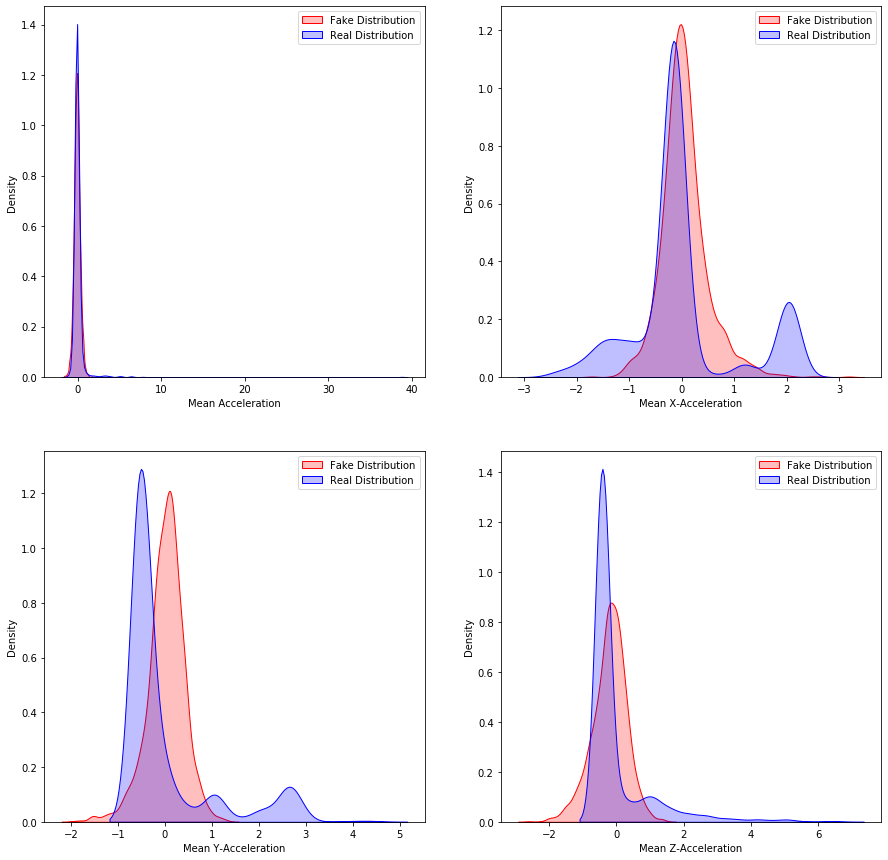

In [10]:
#Number of datum to visualize
sample_size = len(X)
reals = X[0:sample_size, :]
fakes = get_fake_samples(gen, sample_size, z_dim).detach()
density_curves(reals, fakes)

In [11]:
model_output = pd.read_csv('../model_outputs/Test Gan.csv')
model_output.head()

def plot_metrics(data, vanilla = True):
    if vanilla:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    
        plt.figure(figsize = (15, 15))
        subplot(2, 2, 1)
        sns.scatterplot(x = 'Epoch', y = 'FPR', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 2)
        sns.scatterplot(x = 'Epoch', y = 'Recall', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 3)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None), ylim = (0, 0.7))
        sns.despine()
        
        subplot(2, 2, 4)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None), ylim = (0, 0.7))
        sns.despine()
        plt.show()
    else:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
        plt.figure(figsize = (15, 8))
        
        subplot(1, 2, 1)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(1, 2, 2)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        plt.show()

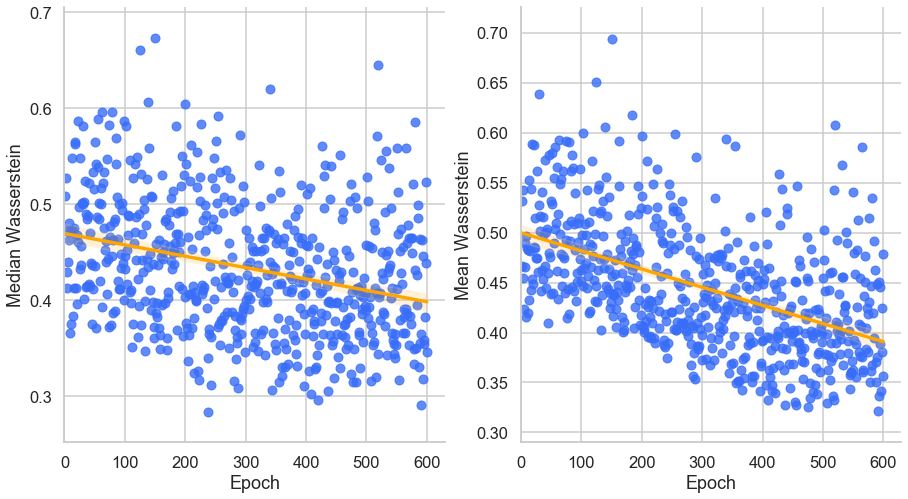

In [12]:
plot_metrics(model_output, False)